In [22]:
import pandas as pd
import numpy as np

import scipy
import statsmodels.formula.api as smf
import statistics as st 
import pandas as pd
import matplotlib.pyplot as plt

import requests
from geopy.geocoders import Nominatim
from astral import LocationInfo
import datetime
from astral.sun import sun
from astral import LocationInfo

from time import time

In [10]:
cd

/Users/karatechop


In [11]:
cd /Users/karatechop/Documents/GitHub/senior-thesis-pretextual-stops/Data/RIPA-DATA-CA-as-of-2022\ \(CSV\)/Waves 3_4/Berkeley PD

/Users/karatechop/Documents/GitHub/senior-thesis-pretextual-stops/Data/RIPA-DATA-CA-as-of-2022 (CSV)/Waves 3_4/Berkeley PD


In [18]:
bpd = pd.read_csv('ALL-BPD-AB953.csv')

In [13]:
bpd.columns

Index(['date', 'time', 'Duration', 'race', 'sex', 'age', 'type',
       'race perceived prior', 'reason', 'offense code', 'basis',
       'actions taken', 'property seized', 'search basis', 'result'],
      dtype='object')

In [19]:
bpd = bpd[['date', 'time', 'race', 'type']]
bpd['date'] = pd.to_datetime(bpd['date'])

In [23]:
sunset_list = []
counter = 0

name = 'Berkeley'
lat = 37.8715
lon = -122.2730
# 37.8715° N, 122.2730°

for i in bpd['date']:
    year = i.year
    month = i.month
    day = i.day

    loc = LocationInfo(name=name, region='CA, USA', timezone='America/Los_Angeles', #https://en.wikipedia.org/wiki/List_of_tz_database_time_zones
                       latitude=lat, longitude=lon)
    


    s = sun(loc.observer, date=datetime.date(year, month, day), tzinfo=loc.timezone)
    for key in ['sunset']:
        sunset_list.append(s[key].time())
        
    counter+=1
    
sunset_list2 = [str(i)[:8] for i in sunset_list]  
bpd['sunsettime'] = sunset_list2

In [27]:
date_to_subtract = datetime.datetime(1900, 1, 1)

bpd['mins_sunset'] = [round(((datetime.datetime.strptime(i, '%H:%M:%S') - date_to_subtract).total_seconds() / 60.0),0) 
                                           for i in sunset_list2]



bpd['time'] = pd.to_datetime(bpd['time'],format="%H:%M")
bpd['mins_stop_time'] = [round(((i - date_to_subtract).total_seconds()/60),0) 
                                           for i in bpd['time']]
bpd['mins_after_sunset'] = bpd['mins_stop_time'] - bpd['mins_sunset']
bpd['day_in_year'] = [i.day for i in bpd['date']]
bpd.head(5)

,date,time,race,type,sunsettime,mins_sunset,mins_stop_time,mins_after_sunset,day_in_year
0,2020-10-01,1900-01-01 11:14:00,Hispanic/Latino,Moving Violation,18:50:54,1131.0,674.0,-457.0,1
1,2020-10-01,1900-01-01 10:15:00,White,Moving Violation,18:50:54,1131.0,615.0,-516.0,1
2,2020-10-01,1900-01-01 09:46:00,White,Moving Violation,18:50:54,1131.0,586.0,-545.0,1
3,2020-10-01,1900-01-01 22:26:00,Hispanic/Latino,Non-moving violation / including registration,18:50:54,1131.0,1346.0,215.0,1
4,2020-10-01,1900-01-01 23:18:00,Black/African American,Moving Violation,18:50:54,1131.0,1398.0,267.0,1


In [38]:
df = bpd
df.race.value_counts()

White                         2074
Black/African American        1952
Hispanic/Latino               1126
Asian                          639
Middle Eastern/South Asian     524
mixed                          116
Pacific Islander                35
Name: race, dtype: int64

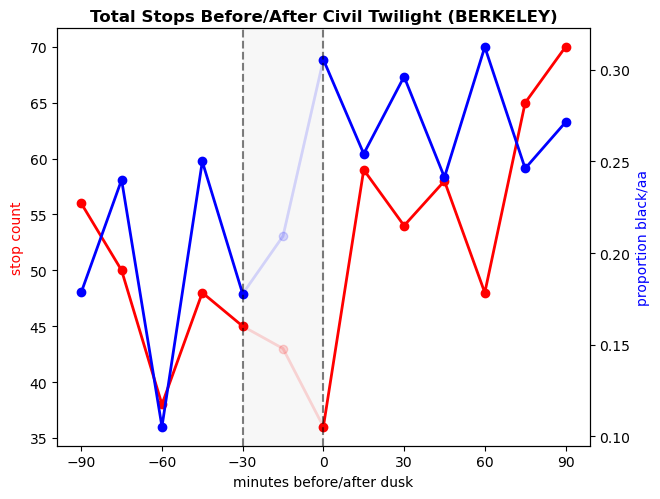

In [46]:
df = df[['date','race','mins_stop_time','mins_sunset','mins_after_sunset','type']]
df1_bw = df[(df['mins_after_sunset'] <= 96) &\
            (df['mins_after_sunset'] >= -96) &\
            (df['type']=='Moving Violation')][['race','mins_stop_time','mins_sunset','mins_after_sunset']]

df1_bw['after_sunset_category'] = [min(np.arange(-90,91,15), key=lambda x:abs(x-i)) for i in df1_bw['mins_after_sunset']]
prop_table = df1_bw.groupby('after_sunset_category',as_index=False).agg('count')[['after_sunset_category','race']]
prop_table['black_aa'] = df1_bw[df1_bw['race']=='Black/African American'].groupby('after_sunset_category',as_index=False)\
                                                                         .agg('count')[['after_sunset_category','race']]\
                                                                         .rename(columns={'race':'black_aa'})['black_aa']

prop_table['prop_black_aa'] = round(prop_table['black_aa']/prop_table['race'],4)

prop_table = prop_table.sort_values(by='after_sunset_category')\
                       .reset_index(drop=True)\
                       .rename(columns={'race':'total_stops',
                                        'black_aa':'black_aa_stops',
                                        'prop_black_aa':'prop'})

prop_table_pre = prop_table[(prop_table['after_sunset_category']<= -30)]
prop_table_post = prop_table[(prop_table['after_sunset_category']>= -1)]
prop_table_dusk = prop_table[(prop_table['after_sunset_category']>= -30) & (prop_table['after_sunset_category']<= 0)]



fig,ax=plt.subplots()

ax.plot(prop_table_pre['after_sunset_category'],prop_table_pre['total_stops'],linewidth=2,c='red',label='reported stops',marker="o")
ax.plot(prop_table_post['after_sunset_category'],prop_table_post['total_stops'],linewidth=2,c='red',label='reported stops',marker="o")
ax.plot(prop_table_dusk['after_sunset_category'],prop_table_dusk['total_stops'],linewidth=2,c='red',alpha=.15,marker="o")

ax.set_xlabel("minutes before/after dusk")
ax.set_ylabel('stop count',c='red')


ax2=ax.twinx()
ax2.plot(prop_table_pre['after_sunset_category'],prop_table_pre['prop'],linewidth=2,c="blue",marker="o")
ax2.plot(prop_table_post['after_sunset_category'],prop_table_post['prop'],linewidth=2,c="blue",marker="o")
ax2.plot(prop_table_dusk['after_sunset_category'],prop_table_dusk['prop'],linewidth=2,c='blue',alpha=.15,marker="o")

ax2.set_ylabel("proportion black/aa",color="blue")


plt.xticks(np.arange(-90,95,30))
plt.axvline(x = 0,c='black',alpha=.5,linestyle='dashed')
plt.axvline(x = -30,c='black',alpha=.5,linestyle='dashed')
plt.axvspan(-30, 0, color='black', alpha=0.03)

plt.title('Total Stops Before/After Civil Twilight (BERKELEY)',weight='semibold',pad=5)
plt.tight_layout(pad=0, w_pad=2, h_pad=2)

plt.show()






# save the plot as a file
# fig.savefig('two_different_y_axis_for_single_python_plot_with_twinx.jpg',
#             format='jpeg',
#             dpi=100,
#             bbox_inches='tight')

In [41]:
prop_table

,after_sunset_category,total_stops,black_aa_stops,prop
0,-90,56,10,0.1786
1,-75,50,12,0.2400
2,-60,38,4,0.1053
3,-45,48,12,0.2500
4,-30,45,8,0.1778
5,-15,43,9,0.2093
6,0,36,11,0.3056
7,15,59,15,0.2542
8,30,54,16,0.2963
9,45,58,14,0.2414
